In [1]:
%load_ext autoreload
%reload_ext autoreload
%env JAX_PLATFORM_NAME=cpu

import jaxtyping  # noqa: F401

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

env: JAX_PLATFORM_NAME=cpu


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax

from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.special import jv

import matplotlib.pyplot as plt

from jaxtyping import PRNGKeyArray, Float, Array, PyTree
from typing import Protocol, runtime_checkable, Any
from jax.typing import ArrayLike
from beartype import beartype

### Config

In [3]:
n_samples = 5_000
test_size = 0.2

batch_size = 64

seed = 0
key = jax.random.PRNGKey(seed)
N_max = 10  # per layer max number of neurons

### Dataset

In [4]:
def bessel(x):
    """
    J_0 + J_1 + J_2
    """
    return jv(0, x) + jv(1, x) + jv(2, x)

In [5]:
x = np.linspace(-2 * np.pi, 2 * np.pi, n_samples).reshape(-1, 1)
y = bessel(x).reshape(-1, 1)

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled, y_scaled = scaler.fit_transform(x), scaler.fit_transform(y)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y_scaled, test_size=0.2, random_state=seed
)

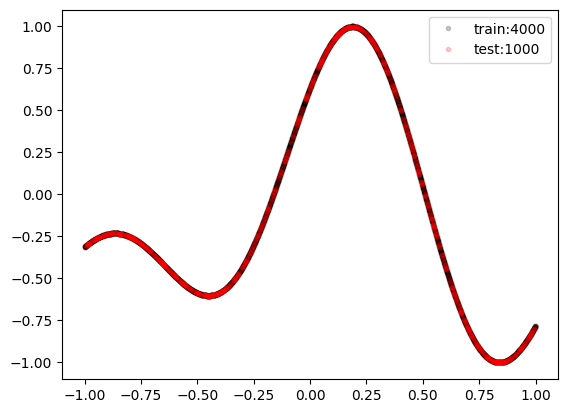

In [8]:
plt.plot(x_train, y_train, "k.", alpha=0.2, label=f"train:{len(x_train)}")
plt.plot(x_test, y_test, "r.", alpha=0.2, label=f"test:{len(x_test)}")
plt.legend()

In [9]:
class DataLoader:
    def __init__(
        self,
        x: Float[Array, "n_samples 1"],
        y: Float[Array, "n_samples 1"],
        batch_size: int,
        key: PRNGKeyArray,
        shuffle: bool = True,
    ):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.num_samples = x.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.key = key

    def __iter__(self):
        if self.shuffle:
            self.key, subkey = jax.random.split(self.key)
            indices = jax.random.permutation(subkey, self.num_samples)
        else:
            indices = np.arange(self.num_samples)

        for i in range(self.num_batches):
            batch_indices = indices[i * self.batch_size : (i + 1) * self.batch_size]
            yield self.x[batch_indices], self.y[batch_indices]

    def __len__(self):
        return self.num_batches

In [10]:
data_key, key = jax.random.split(key)
train_loader = DataLoader(x_train, y_train, batch_size, data_key)
test_loader = DataLoader(x_test, y_test, batch_size, shuffle=False, key=data_key)

TypeCheckError: Type-check error whilst checking the parameters of __main__.DataLoader.__init__.
The problem arose whilst typechecking parameter 'x'.
Actual value: f64[4000,1](numpy)
Expected type: <class 'Float[Array, 'n_samples ...']'>.
----------------------
Called with parameters: {
  'self':
  DataLoader(...),
  'x':
  f64[4000,1](numpy),
  'y':
  f64[4000,1](numpy),
  'batch_size':
  64,
  'key':
  u32[2],
  'shuffle':
  True
}
Parameter annotations: (self, x: Float[Array, 'n_samples ...'], y: Float[Array, 'n_samples ...'], batch_size: int, key: Union[Key[Array, ''], UInt32[Array, '2']], shuffle: bool = True) -> Any.


### Architecture

#### controller

In [11]:
@runtime_checkable
class ControllerLike(Protocol):
    params: Any

    def __call__(self, x: ArrayLike) -> ArrayLike: ...

In [12]:
class controller(eqx.Module):
    dim: int
    params: jax.Array

    def __init__(self, dim: int, key: PRNGKeyArray):
        self.dim = dim
        self.params = jax.random.normal(key, (dim, dim)) * 1e-5

    @beartype
    def __call__(self, x: ArrayLike) -> jnp.ndarray:
        return jnp.dot(x, self.params)

In [13]:
# | test the controller
control = controller(1, key)
control(jnp.ones((1,)))

Array([-2.0584225e-06], dtype=float32)

#### control->mask

In [3]:
@partial(jax.jit, static_argnames="N")
def control_to_mask(control_value: jnp.ndarray, N: int) -> jnp.ndarray:
    """
    Maps the control value to a vector mask of size N.
    The sigmoid of control specifies the number of elements in the vector to set to 1 and 0.
    The intermediate element takes a fractional value.
    """
    # Compute mask_param using vectorized operations
    mask_param = jnp.sin((jnp.pi / 2) * control_value) ** 2
    total_full_ones = jnp.floor(mask_param * N).astype(int)
    fractional_part = mask_param * N - total_full_ones

    # Ensure num_ones is within range [0, N]
    # num_ones = jax.lax.clamp(0, total_full_ones, N).astype(int)
    num_ones = jnp.clip(total_full_ones, 0, N)

    mask = jnp.zeros(N)

    # Use lax.select to create a 1 array of size N and set the first `num_ones` elements to 1
    ones_mask = jnp.arange(N) < num_ones

    # Apply ones_mask to the mask
    mask = jax.lax.select(ones_mask, jnp.ones(N), mask)

    # Set the fractional part at the boundary element if `num_ones < N`
    mask = jax.lax.cond(
        jnp.squeeze(num_ones < N),
        lambda m: m.at[num_ones].set(fractional_part),
        lambda m: m,
        mask,
    )

    return mask

[1.         1.         0.61803436 0.        ]
[0 1 2 3]
[0.        1.        1.2360687 0.       ]


<Figure size 2000x200 with 0 Axes>

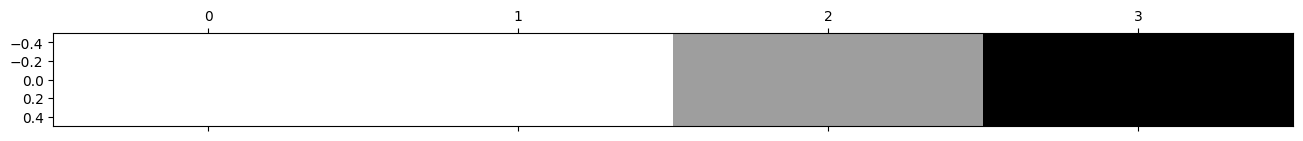

In [7]:
control_value = jnp.array([0.6])
mask = control_to_mask(control_value, 4)
plt.figure(figsize=(20, 2))
plt.matshow(mask.reshape(1, -1), cmap="gray", aspect=0.3)
print(mask)
print(jnp.arange(4))
print(jnp.arange(4) * mask)

#### model

In [17]:
@runtime_checkable
class ModelLike(Protocol):
    def __call__(self, x: ArrayLike, control: ControllerLike) -> ArrayLike: ...

In [18]:
class N3(eqx.Module):
    in_size: int
    out_size: int
    layer_sizes: list[int]
    true_layer_sizes: list[int]
    layers: list[eqx.nn.Linear]

    def __init__(
        self,
        in_size,
        out_size,
        hidden_layer_sizes: list[int],
        key: PRNGKeyArray,
    ):
        self.in_size = in_size + 1  # additional input for size controller
        self.out_size = out_size
        self.layer_sizes = [self.in_size] + hidden_layer_sizes + [self.out_size]
        self.true_layer_sizes = (
            [self.in_size] + [1] * len(hidden_layer_sizes) + [self.out_size]
        )
        keys = jax.random.split(key, len(self.layer_sizes))
        self.layers = [
            eqx.nn.Linear(in_features, out_features, key=keys[key_idx])
            for key_idx, (in_features, out_features) in enumerate(
                zip(self.layer_sizes[:-1], self.layer_sizes[1:])
            )
        ]

    def __call__(
        self, x: ArrayLike, control: ControllerLike
    ) -> Float[jnp.ndarray, "out_size"]:
        control_value = control(jnp.ones((1,)))
        x_new = jnp.concatenate([x, control_value], axis=-1)
        for idx, layer in enumerate(self.layers[:-1]):
            mask = control_to_mask(control_value, self.true_layer_sizes[idx + 1])
            x_new = mask * jax.nn.tanh(layer(x_new))

        return self.layers[-1](x_new)

In [20]:
# | test the model
n3 = N3(1, 1, [10], key)
eqx.filter_vmap(n3, in_axes=(0, None))(x_train[:10], control)

Array([[-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736],
       [-0.17326736]], dtype=float32)

### Training scheme

In [21]:
def compute_base_loss(
    model: ModelLike,
    control: ControllerLike,
    x: Float[Array, "batch 1"],
    y: Float[Array, "batch 1"],
) -> Float[Array, ""]:
    pred = jax.vmap(model, in_axes=(0, None))(x, control)
    return jnp.mean((pred - y) ** 2)

In [22]:
def compute_size_loss(controller: ControllerLike) -> Float[Array, ""]:
    N = controller(jnp.ones((1,)))
    return jnp.mean((N - 1.0) ** 2)

In [23]:
@eqx.filter_jit
def make_step(
    model: ModelLike,
    controller: ControllerLike,
    x: Float[Array, "batch 1"],
    y: Float[Array, "batch 1"],
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
) -> tuple[Float[Array, ""], ModelLike, ControllerLike, optax.OptState]:
    loss_base, grads_base = eqx.filter_value_and_grad(compute_base_loss)(
        model, controller, x, y
    )
    loss_size, grads_size = eqx.filter_value_and_grad(compute_size_loss)(controller)
    loss = loss_base + loss_size

    updates, opt_state = optim.update([grads_base, grads_size], opt_state)

    model = eqx.apply_updates(model, updates[0])  # type: ignore
    controller = eqx.apply_updates(controller, updates[1])  # type: ignore
    return loss, model, controller, opt_state

In [24]:
@eqx.filter_jit
def test_step(
    model: ModelLike,
    controller: ControllerLike,
    x: Float[Array, "batch 1"],
    y: Float[Array, "batch 1"],
) -> Float[Array, ""]:
    return compute_base_loss(model, controller, x, y) + compute_size_loss(controller)

In [25]:
@eqx.filter_jit()
def grad_norm(grads: PyTree) -> Float[Array, ""]:
    return jnp.sqrt(
        sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads))
    )

In [26]:
optim = optax.sgd(learning_rate=3e-4)
opt_state = optim.init(eqx.filter([n3, control], eqx.is_inexact_array))

In [27]:
# | test make_step
make_step(n3, control, x_train[:10], y_train[:10], optim, opt_state)

(Array(1.4248064, dtype=float32),
 N3(
   in_size=2,
   out_size=1,
   layer_sizes=[2, 10, 1],
   true_layer_sizes=[2, 1, 1],
   layers=[
     Linear(
       weight=f32[10,2],
       bias=f32[10],
       in_features=2,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[1,10],
       bias=f32[1],
       in_features=10,
       out_features=1,
       use_bias=True
     )
   ]
 ),
 controller(dim=1, params=f32[1,1]),
 (EmptyState(), EmptyState()))

In [28]:
model_key, control_key = jax.random.split(key)
n3 = N3(1, 1, [N_max], model_key)
control = controller(1, control_key)

optim = optax.sgd(learning_rate=3e-3)
opt_state = optim.init(eqx.filter([n3, control], eqx.is_inexact_array))

In [29]:
epochs = 5_000
epoch_list = []
test_losses = []
train_losses = []
controls2 = []
base_grad_norms = []
control_grad_norms = []

for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        train_loss, n3, control, opt_state = make_step(
            n3, control, x_batch, y_batch, optim, opt_state
        )

    if epoch % 10 == 0:
        epoch_list.append(epoch)
        test_loss = 0
        for x_batch, y_batch in test_loader:
            test_loss += test_step(n3, control, x_batch, y_batch)
        test_loss /= len(test_loader)

        test_losses.append(test_loss)
        train_losses.append(train_loss)
        controls2.append(control.params.item() ** 2)
        control_grad_norms.append(
            grad_norm(eqx.filter_grad(compute_size_loss)(control))
        )
        print(
            f"epoch: {epoch_list[-1]}, train_loss: {train_losses[-1]:.4e}, test_loss: {test_losses[-1]:.4e} control2: {controls2[-1]:.4e}"
        )
        print(f"Control_grad_norm: {control_grad_norms[-1]:.4e}")

epoch: 0, train_loss: 1.0993e+00, test_loss: 9.0394e-01 control2: 9.9566e-02
Control_grad_norm: 1.3689e+00
epoch: 10, train_loss: 2.5790e-01, test_loss: 3.9035e-01 control2: 9.6935e-01
Control_grad_norm: 3.0889e-02
epoch: 20, train_loss: 3.2252e-01, test_loss: 3.8379e-01 control2: 9.9930e-01
Control_grad_norm: 6.9678e-04
epoch: 30, train_loss: 2.6928e-01, test_loss: 3.7884e-01 control2: 9.9998e-01
Control_grad_norm: 1.6689e-05
epoch: 40, train_loss: 3.3336e-01, test_loss: 3.7407e-01 control2: 9.9999e-01
Control_grad_norm: 9.8944e-06
epoch: 50, train_loss: 3.1292e-01, test_loss: 3.6885e-01 control2: 9.9999e-01
Control_grad_norm: 9.8944e-06
epoch: 60, train_loss: 3.6814e-01, test_loss: 3.6270e-01 control2: 9.9999e-01
Control_grad_norm: 9.8944e-06
epoch: 70, train_loss: 4.4989e-01, test_loss: 3.5490e-01 control2: 9.9999e-01
Control_grad_norm: 9.8944e-06
epoch: 80, train_loss: 3.2313e-01, test_loss: 3.4469e-01 control2: 9.9999e-01
Control_grad_norm: 9.8944e-06
epoch: 90, train_loss: 3.0444

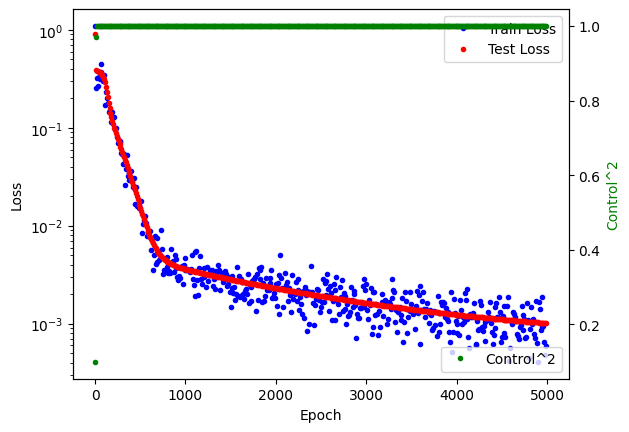

In [35]:
fig, ax1 = plt.subplots()

# Plotting train and test losses
ax1.plot(epoch_list, train_losses, "b.", label="Train Loss")
ax1.plot(epoch_list, test_losses, "r.", label="Test Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="k")
ax1.set_yscale("log")
# ax1.set_xscale("log")

# Creating a second y-axis to plot control gradient norms
ax2 = ax1.twinx()
ax2.plot(epoch_list, controls2, "g.", label="Control^2")
ax2.set_ylabel("Control^2", color="g")

ax1.legend()
ax2.legend()
plt.show()

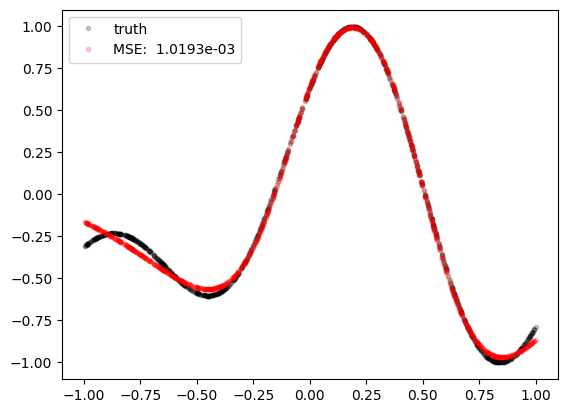

In [31]:
y_pred = jax.vmap(n3, in_axes=(0, None))(x_test, control)
test_loss = jnp.mean((y_pred - y_test) ** 2)

plt.plot(x_test, y_test, "k.", alpha=0.2, label="truth")
plt.plot(x_test, y_pred, "r.", alpha=0.2, label=f"MSE: {test_loss: .4e}")
plt.legend()